In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler ,OneHotEncoder

from feature_engine.datetime import DatetimeFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

In [1]:
pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 6.9 MB/s eta 0:00:00


In [3]:
pd.set_option("display.max_columns",None)


In [4]:
sklearn.set_config(transform_output="pandas")


In [5]:
train_df = pd.read_csv("/content/data/train.csv")
val_df = pd.read_csv("/content/data/val.csv")
test_df = pd.read_csv("/content/data/test.csv")

In [6]:
def split_data(data):
  X = data.drop(columns = "price")
  y = data.price.copy()
  return (X, y)

In [7]:
X_train , y_train = split_data(train_df)
X_test , y_test = split_data(test_df)
X_val , y_val = split_data(val_df)

In [8]:
print(X_train.shape , y_train.shape)


(640, 9) (640,)


In [9]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


In [10]:
dt_cols = ["date_of_journey" , "dep_time" , "arrival_time"]

num_cols = ["duration" , "total_stops"]

cat_cols = [col for col in X_train.columns if (col not in dt_cols ) and (col not in num_cols)]

In [11]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [13]:
num_tansformars = Pipeline(steps = [
    ("imputer" , SimpleImputer(strategy="median")),
    ("scalar" , StandardScaler())
])

cat_tansformars = Pipeline(steps = [
    ("imputer" , SimpleImputer(strategy="most_frequent")),
    ("encoder" , OneHotEncoder(sparse_output=False , handle_unknown="ignore"))
])

doj_transformers = Pipeline(steps = [
    ("imputer" , SimpleImputer(strategy="most_frequent")),
    ("extractor" , DatetimeFeatures(features_to_extract=["month" , "week" , "day_of_week" , "day_of_month"] , format="mixed")),
    ("scalar" , StandardScaler())
])

time_transformers = Pipeline(steps = [
    ("imputer" , SimpleImputer(strategy="most_frequent")),
    ("extractor" , DatetimeFeatures(features_to_extract=["hour" , "minute"] , format="mixed")),
    ("scalar" , StandardScaler())
])

In [14]:
preprocessor = ColumnTransformer(transformers=[
 ("num" , num_tansformars, num_cols),
 ("cat" , cat_tansformars , cat_cols),
 ("doj", doj_transformers , ["date_of_journey"]),
 ("time", time_transformers , ["dep_time" , "arrival_time"])
])

In [15]:
preprocessor.fit_transform(X_train)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.095918,-1.212132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.151587,1.331443,0.566118,0.963554,-0.462055,-0.140057,-0.345231,1.493859
1,1.435699,0.317975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,1.050498,0.604465,-0.640951,-1.229863,-0.935607,0.891041
2,1.824412,1.848082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,1.140212,-0.402640,-0.113711,-0.640951,-0.684960,-0.345231,-1.218823
3,1.904148,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.772093,-1.371399,-1.430369,1.326906,-0.140057,1.278301,1.795268
4,0.847647,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,0.948982,0.081739,-0.831888,0.790218,-1.229863,-0.492825,1.192450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.936446,-1.212132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.580863,0.566118,-0.113711,-1.535432,1.767103,-0.935607,1.192450
636,0.100122,0.317975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.184059,0.081739,-0.472800,-0.640951,0.677297,1.130707,-1.218823
637,-0.946413,-1.212132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-1.177640,-0.957412,-0.788013,1.493859
638,0.189825,0.317975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-0.819847,1.222200,1.130707,-1.520232


In [16]:
algorithms = {
    "Linear Regression" : LinearRegression(),
    "Support Vector Machine" : SVR(),
    "Random Forest " : RandomForestRegressor(n_estimators=10),
    "XG Boost " : XGBRegressor(n_estimators=10)
}

In [17]:
data = pd.concat([train_df , val_df] , axis = 0)

X_data , y_data = split_data(data)

print(X_data.shape , y_data.shape)

(800, 9) (800,)


In [18]:
def plot_curves(sizes, mean_scores, std_scores, label , ax):
  ax.plot(
      sizes,
      mean_scores,
      marker="o",
      label = label
  )

  ax.fill_between(
      x=sizes,
      y1=mean_scores - std_scores,
      y2=mean_scores + std_scores,
      alpha = 0.5
  )


In [19]:
def plot_learning_curves (name , algorithms , figsize=(12 , 4)):
    model = Pipeline(
      steps=[
          ("pre" ,preprocessor),
          ("alg" , algorithms),
    ])
    train_sizes , train_scores , test_scores = learning_curve(
      estimator=model,
      X=X_data,
      y=y_data,
      cv=3,
      scoring="r2",
      n_jobs=-1,
      random_state=42
    )

    mean_train_scores = np.mean(train_scores , axis=1)
    std_train_scores = np.std(train_scores , axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores , axis=1)
    std_test_scores = np.std(test_scores , axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)

    # training curves
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_scores})",
        ax
    )

    # test curves
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test({test_scores})",
        ax
    )

    ax.set(xlabel="Training Set Size" , ylabel="R-square" , title = name)

    ax.legend(loc="lower right")

    plt.show()



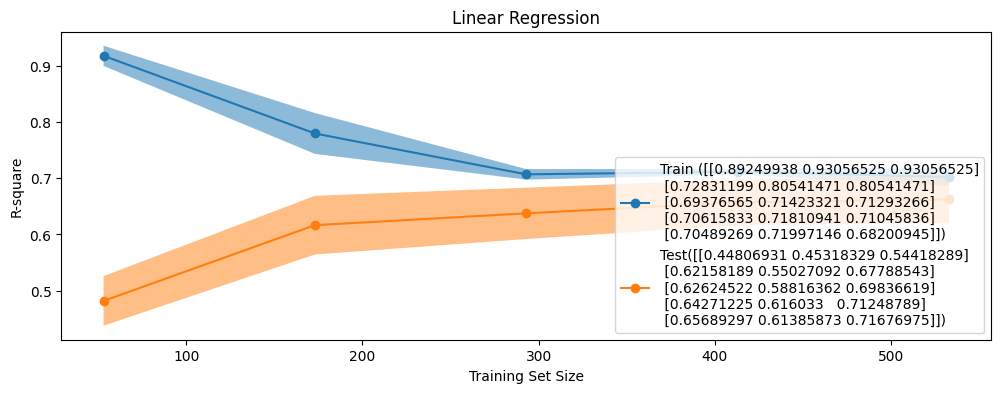

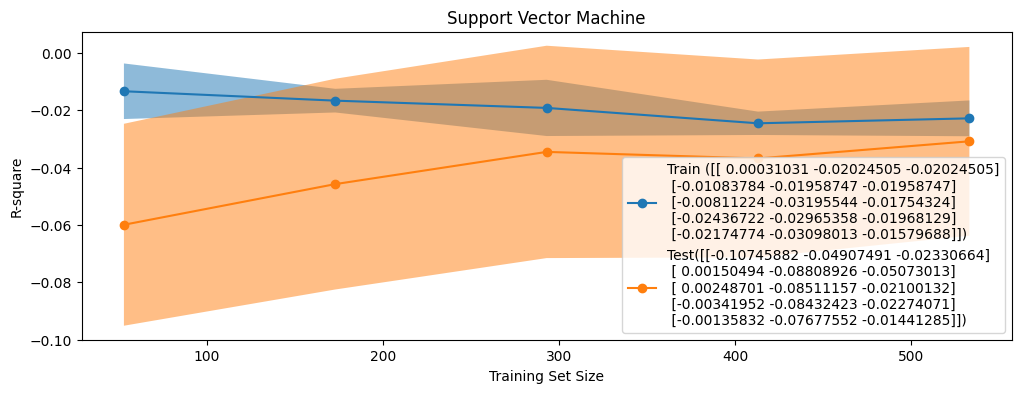

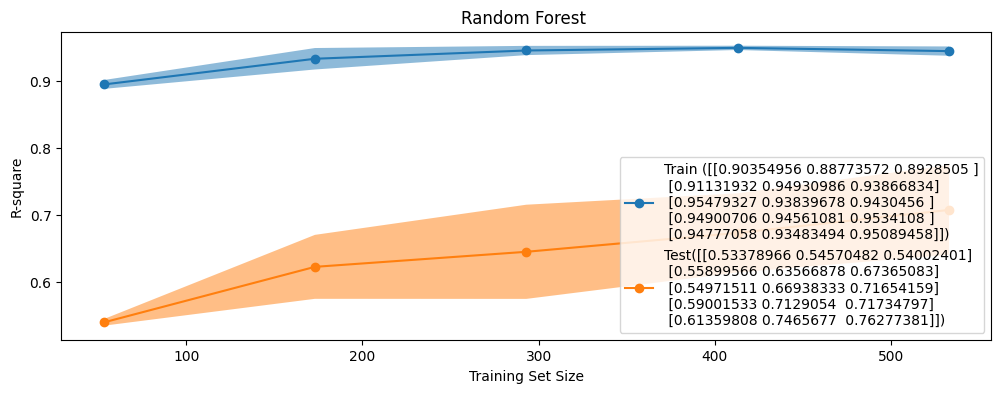

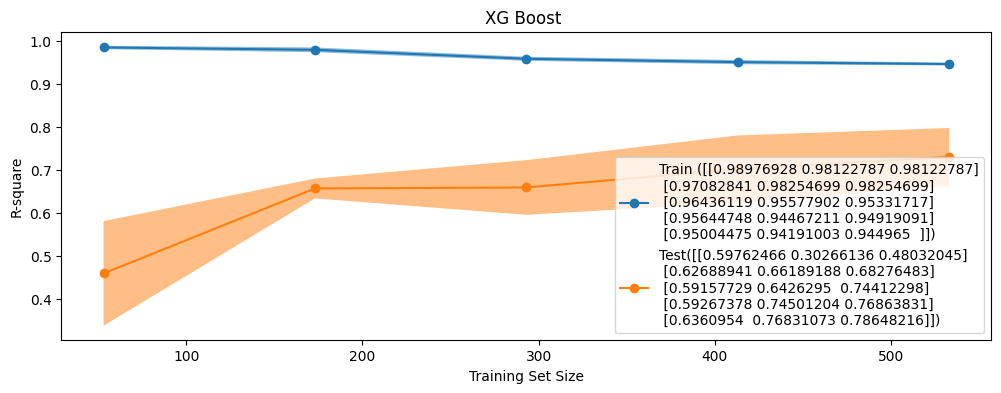

In [20]:
for name, alg in algorithms.items():
  plot_learning_curves(name , alg)

In [21]:
model = Pipeline(steps= [
    ("pre" , preprocessor),
    ("rf" , RandomForestRegressor(n_estimators=10))
])

In [22]:
model.fit(X_data , y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [23]:
def evaluate_model(X ,y):
  y_pred = model.predict(X)
  return r2_score(y,y_pred)

In [24]:
print(f"R2 Score Of Training Data {evaluate_model(X_data , y_data)}" )

R2 Score Of Training Data 0.9514971915411358


In [25]:
print(f"R2 Score Of Test Data {evaluate_model(X_test , y_test)}" )

R2 Score Of Test Data 0.6866461804640169


In [26]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [27]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [28]:
y_pred = saved_model.predict(X_test)

r2_score(y_test , y_pred)

0.6866461804640169